# Gender bias in Bioinformatics

This notebook shows a series of analyses conducted to study gender bians in bioinformatics. By talking the case of studies of the five most important journals in the area (nucleids acid research, bmc genomics, bmc bioinformatics, oxford bioinformatics, plos computational biology) we analyze bias in the autorship of the papers.

In [430]:
%matplotlib inline

# Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, pearsonr

os.chdir('..')

from db_manager import DBManager

plt.style.use('seaborn')

In [3]:
# Save current dir in case it can be useful
project_dir = os.getcwd()

# Data load

In [260]:
papers = pd.read_csv(project_dir + '/data/papers.csv')
authors = pd.read_csv(project_dir + '/data/authors.csv')
papers_authors = pd.read_csv(project_dir + '/data/papers_authors.csv')

In [261]:
print("Raw data:\n-", papers.shape[0], " Papers\n-", authors.shape[0], "Authors\n-", papers_authors.shape[0], 
      "Paper-Authors")

Raw data:
- 38349  Papers
- 120855 Authors
- 213141 Paper-Authors


# Data preprocessing

In [262]:
# Convert vague gender name to specific name
authors.loc[authors['gender']=='mostly_male','gender'] = 'male'
authors.loc[authors['gender']=='mostly_female', 'gender'] = 'female'
papers_authors.loc[papers_authors['author_gender']=='mostly_male','author_gender'] = 'male'
papers_authors.loc[papers_authors['author_gender']=='mostly_female', 'author_gender'] = 'female'

## Remove papers without authors

In [263]:
papers_without_authors = papers[(papers['authors']==0)|(pd.isna(papers['authors']))]
print("Papers without authors " + str(papers_without_authors.shape[0]) + " (most of these are papers " \
      "whose authors have an unidentified gender)")

Papers without authors 1507 (most of these are papers whose authors have an unidentified gender)


In [264]:
papers = papers[(papers['authors']!=0)&(pd.notnull(papers['authors']))]
print("Papers with authors " + str(papers.shape[0]))

Papers with authors 36842


In [265]:
# Remove from papers authors dataset those papers without author
papers_authors = papers_authors[~papers_authors['title'].isin(papers_without_authors)]
papers_authors.shape[0]

213141

## Remove authors with unidentified gender

In [266]:
print("There are " + str(authors[(authors['gender']!='male')&(authors['gender']!='female')].shape[0]) +
      " authors with unidentified gender")

There are 20064 authors with unidentified gender


### Filter out authors with unidentified gender

In [267]:
authors = authors[(authors['gender']=='male')|(authors['gender']=='female')]
authors.shape[0]

100791

In [268]:
# Remove rows that have author with unidentified gender
papers_authors = papers_authors[(papers_authors['author_gender']=='male')|
                                (papers_authors['author_gender']=='female')]
papers_authors.shape[0]

175844

## Check data consistency

In [269]:
# Number of rows in dataframe papers must be equal to the number of rows in dataframe 
# papers_authors after grouping by title
pa_to_check = papers_authors.groupby('title', sort=False, as_index=False)
print("Number of rows are the same: ", pa_to_check.ngroups == papers.shape[0])

Number of rows are the same:  True


In [270]:
# Number of rows in dataframe authors must be equal to the number of rows in dataframe
# papers_authors after grouping by author
pa_to_check = papers_authors.groupby('author', sort=False, as_index=False)
print("Number of rows are the same: ", pa_to_check.ngroups == authors.shape[0])

Number of rows are the same:  True


# Papers

In [271]:
print("Total papers: " + str(papers.shape[0]))

Total papers: 36842


## Data structure

In [272]:
papers.head()

,id,title,DOI,year,source,citations,edamCategory,link,authors,gender_last_author
0,1,A peptide-based method for 13C Metabolic Flux ...,10.1371/journal.pcbi.1003827,2014,plos computational biology,7,Omics > Genomics > Transcriptomics,https://journals.plos.org/ploscompbiol/article...,8.0,male
1,2,Baseline CD4+ T cell counts correlates with HI...,10.1371/journal.pcbi.1003830,2014,plos computational biology,0,Computational Biology > Phylogeny,https://journals.plos.org/ploscompbiol/article...,9.0,male
2,3,Evolution of the F0F1 ATP Synthase Complex in ...,10.1371/journal.pcbi.1003821,2014,plos computational biology,8,Computational Biology > Structure analysis,https://journals.plos.org/ploscompbiol/article...,2.0,female
3,4,Dynamic Modelling of Pathways to Cellular Sene...,10.1371/journal.pcbi.1003728,2014,plos computational biology,12,Computational Biology > Phylogeny,https://journals.plos.org/ploscompbiol/article...,7.0,male
4,5,Unbiased Functional Clustering of Gene Variant...,10.1371/journal.pcbi.1003815,2014,plos computational biology,7,Omics > Genomics > Functional genomics,https://journals.plos.org/ploscompbiol/article...,3.0,male


## Evolution of papers by year

In [273]:
papers_by_year = papers.groupby('year').size()

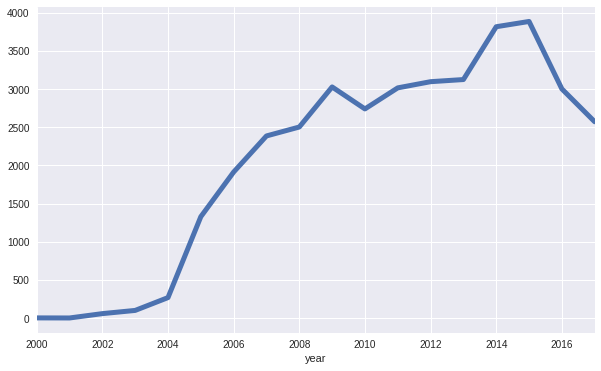

In [274]:
plt.figure(figsize=(10,6))
papers_by_year.plot(lw=5)

## Evolution of average citations over years

In [275]:
papers['citations'].describe()

count    36842.000000
mean        33.426307
std        130.840993
min          0.000000
25%          5.000000
50%         13.000000
75%         31.000000
max       9753.000000
Name: citations, dtype: float64

### Paper with max citation

In [276]:
papers[papers['citations']==max(papers['citations'])].head()

,id,title,DOI,year,source,citations,edamCategory,link,authors,gender_last_author
34840,34841,The Sequence Alignment/Map format and SAMtools,10.1093/bioinformatics/btp352,2009,oxford bioinformatics,9753,Omics > Genomics > Proteomics,https://academic.oup.com/bioinformatics/articl...,8.0,male


### Average citations over years

In [277]:
avg_citations_by_year = papers.groupby('year').mean()['citations']

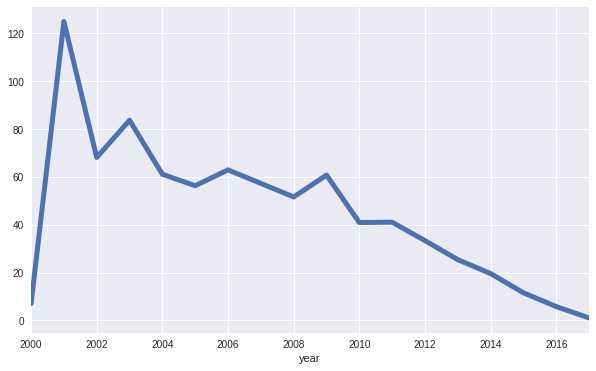

In [278]:
plt.figure(figsize=(10,6))
avg_citations_by_year.plot(lw=5)

## Average authors over years

In [279]:
papers['authors'].describe()

count    36842.000000
mean         4.774659
std          3.665950
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max        130.000000
Name: authors, dtype: float64

### Paper with max number of authors

In [280]:
papers[papers['authors']==max(papers['authors'])].head()

,id,title,DOI,year,source,citations,edamCategory,link,authors,gender_last_author
19896,19897,"The H-Invitational Database (H-InvDB), a compr...",10.1093/nar/gkm999,2008,nucleic acids research,54,Computational Biology > Sequence analysis,https://academic.oup.com/nar/article/36/suppl_...,130.0,male


### Average number of authors over years

In [281]:
avg_authors_by_year = papers.groupby('year').mean()['authors']

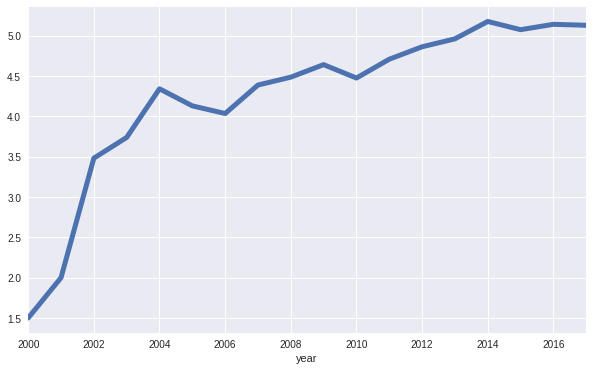

In [282]:
plt.figure(figsize=(10,6))
avg_authors_by_year.plot(lw=5)

## Categories

In [283]:
row_categories = papers['edamCategory']
categories = []
for row_category in row_categories:
    for category in row_category.split('>'):
        clean_category = category.strip()
        exists_category_dict = False
        for category_dict in categories:
            if category_dict['category_name'] == clean_category:
                category_dict['count'] += 1
                exists_category_dict = True
                break
        if not exists_category_dict:
            categories.append(
                {
                    'category_name': clean_category,
                    'count': 1
                }
            )

In [284]:
categories_df = pd.DataFrame(categories)
total_categories = categories_df.shape[0]
print("There are " + str(total_categories) + " categories")
categories_df.sort_values('count', inplace=True, ascending=False)
categories_df.head()

There are 18 categories


,category_name,count
3,Computational Biology,23329
0,Omics,12079
1,Genomics,12079
7,Nucleic acids,6389
6,Functional genomics,5102


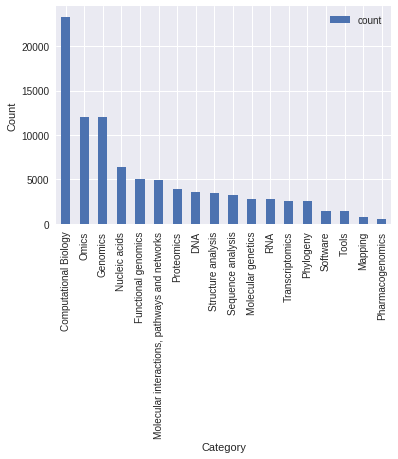

In [285]:
categories_df.plot.bar(x='category_name', y='count')
plt.xticks(rotation=90)
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

## Source

In [286]:
papers_by_source = papers.groupby('source').size().sort_values(ascending=False)

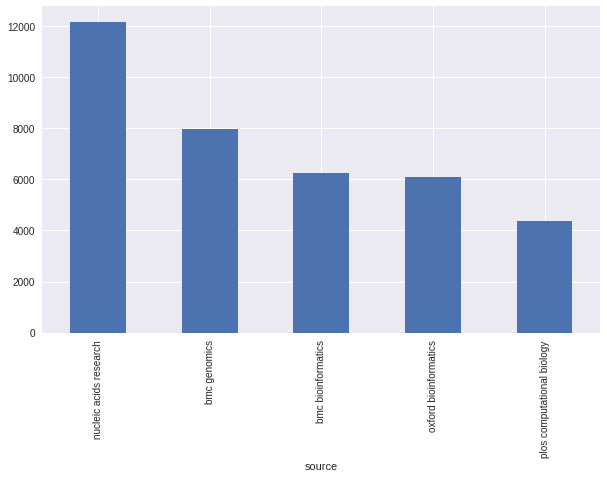

In [287]:
plt.figure(figsize=(10,6))
papers_by_source.plot(kind='bar')

# Authors

In [288]:
print("Total authors: " + str(authors.shape[0]))

Total authors: 100791


## Data structure

In [289]:
authors.head()

,id,name,gender,papers,total_citations,papers_as_first_author,papers_as_last_author,papers_with_citations
0,1,Amit Ghosh,male,3,21,1,0,3
1,2,Jerome Nilmeier,male,1,7,0,0,1
2,3,Paul D Adams,male,3,92,0,0,3
3,4,Jay D Keasling,male,10,214,0,4,10
4,5,Aindrila Mukhopadhyay,female,6,59,0,1,5


## Gender distribution 

In [291]:
authors_by_gender = authors.groupby('gender').size().sort_values(ascending=False)
per_authors_by_gender = authors_by_gender/authors.shape[0]
per_authors_by_gender

gender
male      0.653918
female    0.346082
dtype: float64

In [292]:
authors_by_gender

gender
male      65909
female    34882
dtype: int64

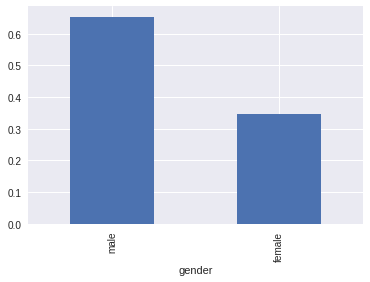

In [293]:
per_authors_by_gender.plot.bar()

## Papers

### Citations per paper

In [294]:
authors['total_citations'].describe()

count    100791.000000
mean         68.891419
std         282.991646
min           0.000000
25%           6.000000
50%          19.000000
75%          50.000000
max       24962.000000
Name: total_citations, dtype: float64

### Author with max number of citations

In [295]:
authors[authors['total_citations']==max(authors['total_citations'])]

,id,name,gender,papers,total_citations,papers_as_first_author,papers_as_last_author,papers_with_citations
7298,7299,Richard Durbin,male,21,24962,1,12,20


### Top-10 Most cited authors

In [296]:
authors.sort_values('total_citations', inplace=True, ascending=False)
authors[['name','gender','total_citations']].head(10)

,name,gender,total_citations
7298,Richard Durbin,male,24962
119245,Goncalo R Abecasis,male,22031
16979,Alexandros Stamatakis,male,12752
3204,Peer Bork,male,12624
25815,Minoru Kanehisa,male,10150
51102,Jue Ruan,female,9984
21503,Nils Homer,male,9827
113603,Tim Fennell,male,9821
33544,Gabor Marth,male,9782
115239,Alec Wysoker,male,9753


#### Top-10 most cited female authors

In [297]:
authors.sort_values('total_citations', inplace=True, ascending=False)
authors[authors['gender']=='female'][['name','gender','total_citations']].head(10)

,name,gender,total_citations
51102,Jue Ruan,female,9984
76793,Miho Furumichi,female,5232
76794,Mao Tanabe,female,5232
21794,Fiona Cunningham,female,4685
84281,Narmada Thanki,female,4501
84270,Myra K Derbyshire,female,4446
84282,Roxanne A Yamashita,female,4446
84278,Gabriele H Marchler,female,4446
84272,Noreen R Gonzales,female,4446
72241,Donna R Maglott,female,4408


### Papers per author

In [298]:
authors['papers'].describe()

count    100791.000000
mean          1.744203
std           2.037502
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          69.000000
Name: papers, dtype: float64

### Top-10 Most productive author

In [299]:
authors.sort_values('papers', inplace=True, ascending=False)
authors[['name','gender','papers']].head(10)

,name,gender,papers
3213,Janusz M Bujnicki,male,69
7970,Peter F Stadler,male,69
3204,Peer Bork,male,53
4050,Alfonso Valencia,male,51
1923,Jun Wang,male,48
265,Philip E Bourne,male,48
3380,Mark Gerstein,male,46
3087,Yan Zhang,male,45
67606,Christine Anne Orengo,female,44
9368,Rolf Backofen,male,41


#### Top-10 most productive female authors

In [300]:
authors.sort_values('papers', inplace=True, ascending=False)
authors[authors['gender']=='female'][['name','gender','papers']].head(10)

,name,gender,papers
67606,Christine Anne Orengo,female,44
763,Olga G Troyanskaya,female,35
17171,Rita Casadio,female,34
1829,Luonan Chen,female,32
62,Jin Wang,female,30
17135,Sophia Ananiadou,female,29
107,Ruth Nussinov,female,29
17500,Lin Liu,female,28
2421,Shoba Ranganathan,female,28
13405,Cathy H Wu,female,26


### Papers as first author

In [301]:
authors['papers_as_first_author'].describe()

count    100791.000000
mean          0.307051
std           0.637747
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.000000
Name: papers_as_first_author, dtype: float64

### Top-10 authors that appeared as first author

In [302]:
authors.sort_values('papers_as_first_author', inplace=True, ascending=False)
authors[['name','gender','papers','papers_as_first_author']].head(10)

,name,gender,papers,papers_as_first_author
8645,Kai Wang,male,32,13
18426,Shuangge Ma,female,17,12
10750,Robert Hoehndorf,male,16,11
3087,Yan Zhang,male,45,10
19360,Stephen Winters-Hilt,male,17,10
15633,Richard Tzong-Han Tsai,male,11,9
17794,Castrense Savojardo,male,12,9
18876,Christina Backes,female,22,9
9282,Andrey A Ptitsyn,male,10,9
3201,Wei-Hua Chen,female,10,8


#### Top-10 female authors that appeared as first author

In [303]:
authors.sort_values('papers_as_first_author', inplace=True, ascending=False)
authors[authors['gender']=='female'][['name','gender','papers','papers_as_first_author']].head(10)

,name,gender,papers,papers_as_first_author
18426,Shuangge Ma,female,17,12
18876,Christina Backes,female,22,9
3201,Wei-Hua Chen,female,10,8
25946,Milana Frenkel-Morgenstern,female,8,7
78641,Agnieszka Kiliszek,female,7,7
84521,Cristina Aurrecoechea,female,9,7
24102,Monica Chagoyen,female,9,6
19405,Eva Freyhult,female,8,6
86019,Rachel M Smith,female,8,6
21533,Kaname Kojima,female,15,6


### Papers as last author

In [304]:
authors['papers_as_last_author'].describe()

count    100791.000000
mean          0.319443
std           1.166163
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          40.000000
Name: papers_as_last_author, dtype: float64

### Top-10 authors that appeared as first author

In [305]:
authors.sort_values('papers_as_last_author', inplace=True, ascending=False)
authors[['name','gender','papers','papers_as_last_author']].head(10)

,name,gender,papers,papers_as_last_author
3380,Mark Gerstein,male,46,40
3213,Janusz M Bujnicki,male,69,38
120826,William Stafford Noble,male,40,32
709,Nick V Grishin,male,35,32
3204,Peer Bork,male,53,32
4116,Adam Godzik,male,40,31
763,Olga G Troyanskaya,female,35,31
14674,Edward R Dougherty,male,30,29
3994,David S Wishart,male,37,29
265,Philip E Bourne,male,48,28


#### Top-10 female authors that appeared as first author

In [306]:
authors.sort_values('papers_as_last_author', inplace=True, ascending=False)
authors[authors['gender']=='female'][['name','gender','papers','papers_as_last_author']].head(10)

,name,gender,papers,papers_as_last_author
763,Olga G Troyanskaya,female,35,31
17171,Rita Casadio,female,34,28
67606,Christine Anne Orengo,female,44,27
17135,Sophia Ananiadou,female,29,23
2421,Shoba Ranganathan,female,28,23
1829,Luonan Chen,female,32,21
17301,Manuela Helmer-Citterich,female,26,19
338,Ivet Bahar,female,24,19
120804,Charlotte M Deane,female,26,19
2898,Jinn-Moon Yang,female,21,19


## Papers without citations

In [307]:
authors['papers_without_citations'] = authors['papers'] - authors['papers_with_citations']
authors[['id','name','gender','papers','papers_without_citations']].head()

,id,name,gender,papers,papers_without_citations
3380,3381,Mark Gerstein,male,46,2
3213,3214,Janusz M Bujnicki,male,69,2
120826,120827,William Stafford Noble,male,40,3
709,710,Nick V Grishin,male,35,1
3204,3205,Peer Bork,male,53,2


In [308]:
authors['papers_without_citations'].describe()

count    100791.000000
mean          0.115854
std           0.349140
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: papers_without_citations, dtype: float64

# Authorship

## Data structure

In [309]:
papers_authors.head()

,id,title,doi,year,category,author,author_gender,author_position
0,1,A peptide-based method for 13C Metabolic Flux ...,10.1371/journal.pcbi.1003827,2014,Omics > Genomics > Transcriptomics,Amit Ghosh,male,1
1,2,A peptide-based method for 13C Metabolic Flux ...,10.1371/journal.pcbi.1003827,2014,Omics > Genomics > Transcriptomics,Jerome Nilmeier,male,2
2,3,A peptide-based method for 13C Metabolic Flux ...,10.1371/journal.pcbi.1003827,2014,Omics > Genomics > Transcriptomics,Daniel B Weaver,male,3
3,4,A peptide-based method for 13C Metabolic Flux ...,10.1371/journal.pcbi.1003827,2014,Omics > Genomics > Transcriptomics,Paul D Adams,male,4
4,5,A peptide-based method for 13C Metabolic Flux ...,10.1371/journal.pcbi.1003827,2014,Omics > Genomics > Transcriptomics,Jay D Keasling,male,5


In [357]:
papers_grouped_by_title = papers_authors.drop(['id', 'doi', 'year', 'category', 'author', 'author_position'], axis=1).groupby(['title','author_gender'], sort=False, as_index=False)
agg_papers_grouped_df = papers_grouped_by_title[['author_gender']].agg({'author_gender': {'count_gender': 'count'}})
agg_papers_grouped_df.head()

,title,author_gender,count_gender
0,A peptide-based method for 13C Metabolic Flux ...,male,6
1,A peptide-based method for 13C Metabolic Flux ...,female,2
2,Baseline CD4+ T cell counts correlates with HI...,female,2
3,Baseline CD4+ T cell counts correlates with HI...,male,4
4,Evolution of the F0F1 ATP Synthase Complex in ...,female,2


In [358]:
papers_gender_dist = agg_papers_grouped_df.pivot(columns='author_gender', values='count_gender', index='title')
papers_gender_dist = papers_gender_dist.fillna(0)
papers_gender_dist.head()

author_gender,female,male
title,,
'Bois noir' phytoplasma induces significant reprogramming of the leaf transcriptome in the field grown grapevine,1.0,9.0
'Brukin2D': A 2D visualization and comparison tool for LC-MS data,2.0,6.0
"'Evidence of an auxin signal pathway, microRNA167-ARF8-GH3, and its response to exogenous auxin in cultured rice cells'",2.0,0.0
'Genome design' model and multicellular complexity: Golden middle,0.0,3.0
'HypothesisFinder:' A Strategy for the Detection of Speculative Statements in Scientific Text,8.0,6.0


In [359]:
papers_gender_dist['most_female'] = np.where(papers_gender_dist['female']>papers_gender_dist['male'], 1, 0)
papers_gender_dist['most_male'] = np.where(papers_gender_dist['male']>papers_gender_dist['female'], 1, 0)
papers_gender_dist['equal_gender'] = np.where(papers_gender_dist['male']==papers_gender_dist['female'], 1, 0)
papers_gender_dist['only_male'] = np.where(papers_gender_dist['female']==0, 1, 0)
papers_gender_dist['only_female'] = np.where(papers_gender_dist['male']==0, 1, 0)
papers_gender_dist.head()

author_gender,female,male,most_female,most_male,equal_gender,only_male,only_female
title,,,,,,,
'Bois noir' phytoplasma induces significant reprogramming of the leaf transcriptome in the field grown grapevine,1.0,9.0,0,1,0,0,0
'Brukin2D': A 2D visualization and comparison tool for LC-MS data,2.0,6.0,0,1,0,0,0
"'Evidence of an auxin signal pathway, microRNA167-ARF8-GH3, and its response to exogenous auxin in cultured rice cells'",2.0,0.0,1,0,0,0,1
'Genome design' model and multicellular complexity: Golden middle,0.0,3.0,0,1,0,1,0
'HypothesisFinder:' A Strategy for the Detection of Speculative Statements in Scientific Text,8.0,6.0,1,0,0,0,0


## Papers with mostly male authors

In [316]:
raw_num = papers_gender_dist['most_male'].sum()
per_num = round(raw_num/papers_gender_dist.shape[0]*100,2)
print('There are {}({}%) papers which have mostly male authors'.format(raw_num, per_num))

There are 21956(59.6%) papers which have mostly male authors


## Papers with mostly female authors

In [317]:
raw_num = papers_gender_dist['most_female'].sum()
per_num = round(raw_num/papers_gender_dist.shape[0]*100,2)
print('There are {}({}%) papers which have mostly female authors'.format(raw_num, per_num))

There are 10540(28.61%) papers which have mostly female authors


## Papers with only male authors

In [318]:
raw_num = papers_gender_dist['only_male'].sum()
per_num = round(raw_num/papers_gender_dist.shape[0]*100,2)
print('There are {}({}%) papers which have only male authors'.format(raw_num, per_num))

There are 12687(34.44%) papers which have only male authors


## Papers with only female authors

In [319]:
raw_num = papers_gender_dist['only_female'].sum()
per_num = round(raw_num/papers_gender_dist.shape[0]*100,2)
print('There are {}({}%) papers which have only female authors'.format(raw_num, per_num))

There are 1442(3.91%) papers which have only female authors


## Papers with equal number of male and female authors

In [320]:
raw_num = papers_gender_dist['equal_gender'].sum()
per_num = round(raw_num/papers_gender_dist.shape[0]*100,2)
print('There are {}({}%) papers which have equal number of male and female authors'.format(raw_num, per_num))

There are 4346(11.8%) papers which have equal number of male and female authors


## Distribution of first author gender

Only first authors with identified gender (male/female) are considered in the analysis. The total does not sum up 1 because there are first author with an unidentified gender.

In [339]:
papers_authors[papers_authors['author_position']==1].author_gender.value_counts()/papers.shape[0]

male      0.578090
female    0.262689
Name: author_gender, dtype: float64

## Number of papers with a woman as first author

Only first authors with identified gender (male/female) are considered in the analysis.

In [340]:
raw_num = papers_authors[(papers_authors['author_gender']=='female')&(papers_authors['author_position']==1)].shape[0]
per_num = round(raw_num/papers.shape[0]*100,2)
print('There are {}({}%) papers which have a woman as the first author'.format(raw_num, per_num))

There are 9678(26.27%) papers which have a woman as the first author


## Number of papers with a man as first author

Only first authors with identified gender (male/female) are considered in the analysis.

In [341]:
raw_num = papers_authors[(papers_authors['author_gender']=='male')&(papers_authors['author_position']==1)].shape[0]
per_num = round(raw_num/papers.shape[0]*100,2)
print('There are {}({}%) papers which have a man as the first author'.format(raw_num, per_num))

There are 21298(57.81%) papers which have a man as the first author


## Evolution of male and female authors by year

In [360]:
papers_grouped_by_year = papers_authors.drop(['id', 'title', 'doi', 'category', 'author', 'author_position'], axis=1).\
    groupby(['year','author_gender'], as_index=False)
agg_papers_grouped_df = papers_grouped_by_year[['author_gender']].agg({'author_gender': {'count_gender': 'count'}})

In [361]:
papers_gender_dist_by_year = agg_papers_grouped_df.pivot(columns='author_gender', values='count_gender', 
                                                         index='year')
papers_gender_dist_by_year = papers_gender_dist_by_year.fillna(0)
papers_gender_dist_by_year.head()

author_gender,female,male
year,,
2000,2,1
2001,1,1
2002,55,147
2003,100,274
2004,289,875


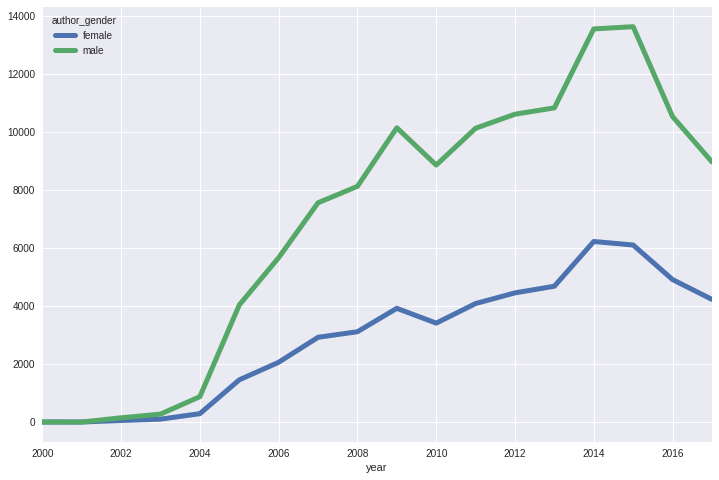

In [362]:
papers_gender_dist_by_year.plot(lw=5)
plt.gcf().set_size_inches(12, 8)

## Position in papers of female authors

In [346]:
# filter out male authors
female_authors = papers_authors[papers_authors['author_gender']=='female']
# drop unneccesary columns
female_authors = female_authors.drop(['id', 'title', 'doi', 'year', 'category', 'author_gender'], axis=1)
# group rows authors by author
female_authors_grouped_by_position = female_authors.groupby(['author','author_position'], as_index=False)
# compute frequency of positions
agg_fa_grouped_df = female_authors_grouped_by_position[['author_position']].\
    agg({'author_position': {'count_position': 'count'}})
# pivot table
female_authors_pos = agg_fa_grouped_df.pivot(columns='author_position', values='count_position', index='author')
# fill na values with zero
female_authors_pos = female_authors_pos.fillna(0)
female_authors_pos.head()

author_position,1,2,3,4,5,6,7,8,9,10,...,92,93,95,103,107,117,118,120,126,129
author,,,,,,,,,,,,,,,,,,,,,
A A Fedorova,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bendoraite,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A K Shchyolkina,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A V Lapuk,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A-Lien Lu,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [347]:
female_authors_pos['freq_pos'] = female_authors_pos.idxmax(axis=1)  #.value_counts()[:10]

In [348]:
female_authors_pos[female_authors_pos['freq_pos']==1].head(10)

author_position,1,2,3,4,5,6,7,8,9,10,...,93,95,103,107,117,118,120,126,129,freq_pos
author,,,,,,,,,,,,,,,,,,,,,
Aafke A van den Berg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Aafke W F Janssen,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Aakrosh Ratan,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Aamira Tariq,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Aanchal Katoch,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Aarti Garg,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Aarti Sevilimedu,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Abbey B Holt,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Abha Singh Bais,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Positions most frequently occuped by female authors in papers

In [349]:
female_authors_pos['freq_pos'].value_counts()[:10]

1     7741
2     6807
3     5624
4     4269
5     2987
6     2156
7     1524
8      978
9      682
10     473
Name: freq_pos, dtype: int64

In [353]:
title_papers_led_female = papers_authors[(papers_authors['author_gender']=='female') & \
                                         (papers_authors['author_position']==1)]['title']
papers_led_female = papers_authors[papers_authors['title'].isin(title_papers_led_female)]
papers_led_female = papers_led_female.drop(['id', 'doi', 'year', 'category', 'author', 'author_position'], axis=1)
papers_led_female_grouped_by_title = papers_led_female.groupby(['title','author_gender'], \
                                                               sort=False, as_index=False)
agg_papers_grouped_lbf = papers_led_female_grouped_by_title[['author_gender']].\
    agg({'author_gender': {'count_gender': 'count'}})
papers_led_female_df = agg_papers_grouped_lbf.pivot(columns='author_gender', values='count_gender', index='title') 
papers_led_female_df = papers_led_female_df.fillna(0)
num_papers_led_by_woman = papers_led_female_df.shape[0]
per_papers_led_by_woman = round(num_papers_led_by_woman/papers.shape[0]*100,2)
print('There are {} ({}%) papers led by a woman (only first authors with '
      'identified gender as considered in the analysis)'.format(num_papers_led_by_woman, per_papers_led_by_woman))
num_papers_led_by_woman_men = papers_led_female_df[papers_led_female_df['male']>0].shape[0]
per_papers_led_by_woman_men = round(num_papers_led_by_woman_men/num_papers_led_by_woman*100,2)
print('In {} ({}%) of this papers there are also men as co-authors'.format(num_papers_led_by_woman_men, \
                                                                          per_papers_led_by_woman_men))

There are 9678 (26.27%) papers led by a woman (only first authors with identified gender as considered in the analysis)
In 8917 (92.14%) of this papers there are also men as co-authors


## Citations by gender

### Citations of papers with mostly female and male authors

In [363]:
papers_with_most_females = papers_gender_dist[papers_gender_dist['most_female']==1].index.values
c_mostly_female_authors = papers[papers['title'].isin(papers_with_most_females)]['citations']
papers_with_most_male = papers_gender_dist[papers_gender_dist['most_male']==1].index.values
c_mostly_male_authors = papers[papers['title'].isin(papers_with_most_male)]['citations']

In [364]:
c_mostly_female_authors.describe()

count    10540.000000
mean        30.656357
std        126.424511
min          0.000000
25%          5.000000
50%         13.000000
75%         30.000000
max       9753.000000
Name: citations, dtype: float64

In [365]:
c_mostly_male_authors.describe()

count    21956.000000
mean        35.227227
std        139.904337
min          0.000000
25%          5.000000
50%         13.000000
75%         31.000000
max       9254.000000
Name: citations, dtype: float64

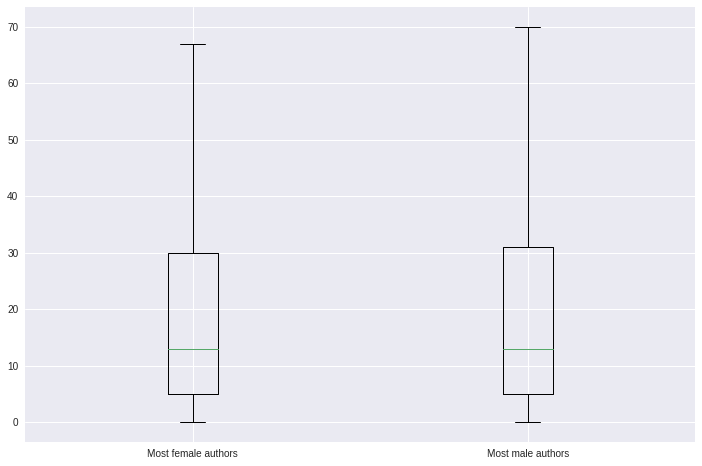

In [366]:
data_to_plot = [c_mostly_female_authors, c_mostly_male_authors]
# Create a figure instance
fig = plt.figure(1, figsize=(12, 8))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['Most female authors', 'Most male authors'])
# Create the boxplot
bp = ax.boxplot(data_to_plot, showfliers=False)

#### Are the different statistically significant?

In [367]:
ttest,pval = ttest_ind(c_mostly_female_authors,c_mostly_male_authors)
if pval < 0.05:
    print("The difference is statistically significant, p-value:",round(pval,3))
else:
    print("The difference is not statistically significant, p-value:",round(pval,3))

The difference is statistically significant, p-value: 0.004


### Citations of papers with only female and male authors

In [368]:
papers_with_most_females = papers_gender_dist[papers_gender_dist['only_female']==1].index.values
c_only_female_authors = papers[papers['title'].isin(papers_with_most_females)]['citations']
papers_with_most_male = papers_gender_dist[papers_gender_dist['only_male']==1].index.values
c_only_male_authors = papers[papers['title'].isin(papers_with_most_male)]['citations']

In [369]:
c_only_female_authors.describe()

count    1442.000000
mean       24.538141
std        80.272499
min         0.000000
25%         3.250000
50%        10.000000
75%        25.000000
max      2115.000000
Name: citations, dtype: float64

In [370]:
c_only_male_authors.describe()

count    12687.000000
mean        37.279656
std        165.227185
min          0.000000
25%          5.000000
50%         13.000000
75%         32.000000
max       9254.000000
Name: citations, dtype: float64

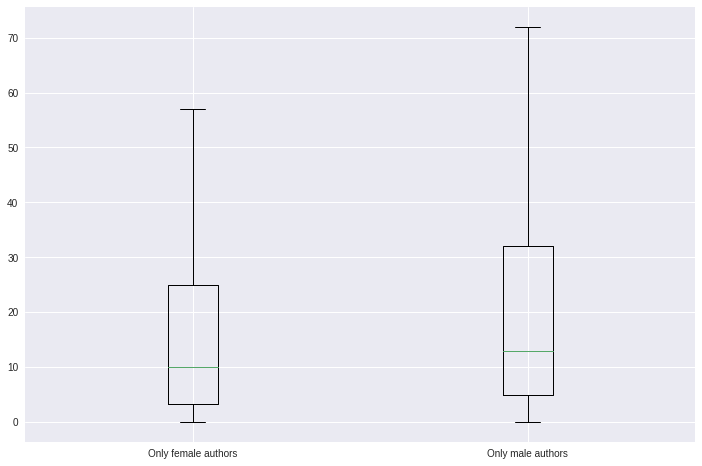

In [371]:
data_to_plot = [c_only_female_authors, c_only_male_authors]
# Create a figure instance
fig = plt.figure(1, figsize=(12, 8))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['Only female authors', 'Only male authors'])
# Create the boxplot
bp = ax.boxplot(data_to_plot, showfliers=False)

#### Are the different statistically significant?

In [372]:
ttest,pval = ttest_ind(c_only_female_authors,c_only_male_authors)
if pval < 0.05:
    print("The difference is statistically significant, p-value:",round(pval,3))
else:
    print("The difference is not statistically significant, p-value:",round(pval,3))

The difference is statistically significant, p-value: 0.004


### Citations of papers led by female and male authors

In [373]:
# citations led by female authors
c_led_female_authors = papers[papers['title'].isin(papers_led_female_df.index.values)]['citations']
# citations led by male authors
title_papers_led_male = papers_authors[(papers_authors['author_gender']=='male') & \
                                       (papers_authors['author_position']==1)]['title']
papers_led_male = papers_authors[papers_authors['title'].isin(title_papers_led_male)]
papers_led_male = papers_led_male.drop(['id', 'doi', 'year', 'category', 'author', 'author_position'], axis=1)
papers_led_male_grouped_by_title = papers_led_male.groupby(['title','author_gender'], sort=False, as_index=False)
agg_papers_grouped_lbm = papers_led_male_grouped_by_title[['author_gender']].\
    agg({'author_gender': {'count_gender': 'count'}})
papers_led_male_df = agg_papers_grouped_lbm.pivot(columns='author_gender', values='count_gender', index='title')
c_led_male_authors = papers[papers['title'].isin(papers_led_male_df.index.values)]['citations']

/home/jorge/python_venvs/gender_identification/lib/python3.6/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [374]:
c_led_female_authors.describe()

count    9678.000000
mean       28.173280
std        78.587522
min         0.000000
25%         5.000000
50%        13.000000
75%        29.000000
max      2686.000000
Name: citations, dtype: float64

In [375]:
c_led_male_authors.describe()

count    21298.000000
mean        36.086957
std        128.383329
min          0.000000
25%          5.000000
50%         14.000000
75%         32.000000
max       8608.000000
Name: citations, dtype: float64

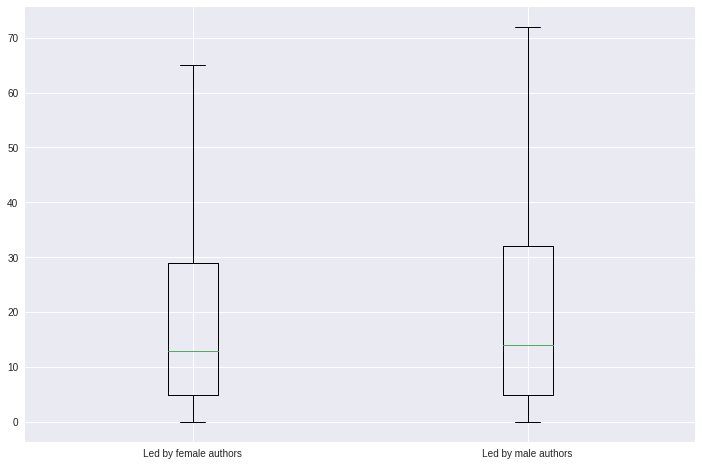

In [376]:
data_to_plot = [c_led_female_authors, c_led_male_authors]
# Create a figure instance
fig = plt.figure(1, figsize=(12, 8))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['Led by female authors', 'Led by male authors'])
# Create the boxplot
bp = ax.boxplot(data_to_plot, showfliers=False)

#### Are the different statistically significant?

In [383]:
ttest,pval = ttest_ind(c_led_female_authors,c_led_male_authors)
if pval < 0.05:
    print("The difference is statistically significant, p-value:", pval)
else:
    print("The difference is not statistically significant, p-value:",round(pval,3))

The difference is statistically significant, p-value: 2.0937046366086256e-08


### Citations of papers with female and male authors as last authors

In [378]:
citations_papers_female_author = papers[papers['gender_last_author']=='female']['citations']
citations_papers_male_author = papers[papers['gender_last_author']=='male']['citations']

In [379]:
citations_papers_female_author.describe()

count    7896.000000
mean       26.544453
std        70.135201
min         0.000000
25%         4.000000
50%        12.000000
75%        27.000000
max      2115.000000
Name: citations, dtype: float64

In [380]:
citations_papers_male_author.describe()

count    28829.000000
mean        35.361025
std        143.206904
min          0.000000
25%          5.000000
50%         13.000000
75%         32.000000
max       9753.000000
Name: citations, dtype: float64

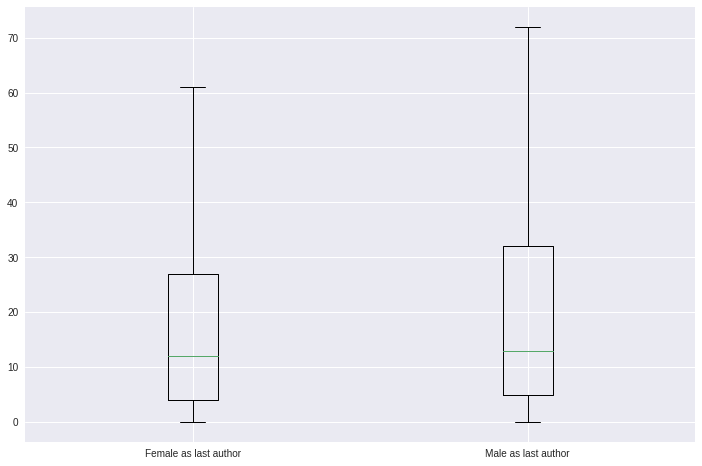

In [381]:
data_to_plot = [citations_papers_female_author, citations_papers_male_author]
# Create a figure instance
fig = plt.figure(1, figsize=(12, 8))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['Female as last author', 'Male as last author'])
# Create the boxplot
bp = ax.boxplot(data_to_plot, showfliers=False)

#### Are the different statistically significant?

In [382]:
ttest,pval = ttest_ind(citations_papers_female_author, citations_papers_male_author)
if pval < 0.05:
    print("The difference is statistically significant, p-value:",pval)
else:
    print("The difference is not statistically significant, p-value:",round(pval,3))

The difference is statistically significant, p-value: 1.1690383524900284e-07


### Correlation between citations and gender distribution

In [392]:
papers_gender_dist['gender_ratio'] = np.where(papers_gender_dist['male'] > 0, 
                                              papers_gender_dist['female']/papers_gender_dist['male'], 
                                              50)

In [393]:
papers_gender_dist.head()

author_gender,female,male,most_female,most_male,equal_gender,only_male,only_female,gender_ratio
title,,,,,,,,
'Bois noir' phytoplasma induces significant reprogramming of the leaf transcriptome in the field grown grapevine,1.0,9.0,0,1,0,0,0,0.111111
'Brukin2D': A 2D visualization and comparison tool for LC-MS data,2.0,6.0,0,1,0,0,0,0.333333
"'Evidence of an auxin signal pathway, microRNA167-ARF8-GH3, and its response to exogenous auxin in cultured rice cells'",2.0,0.0,1,0,0,0,1,50.000000
'Genome design' model and multicellular complexity: Golden middle,0.0,3.0,0,1,0,1,0,0.000000
'HypothesisFinder:' A Strategy for the Detection of Speculative Statements in Scientific Text,8.0,6.0,1,0,0,0,0,1.333333


In [416]:
papers_gdr = pd.DataFrame({'title': papers_gender_dist.index.values,
                           'female': papers_gender_dist['female'],
                           'male': papers_gender_dist['male'],
                           'gender_ratio':papers_gender_dist['gender_ratio']},
                          index=papers_gender_dist.index.values)

In [417]:
papers_gdr.head()

,title,female,male,gender_ratio
'Bois noir' phytoplasma induces significant reprogramming of the leaf transcriptome in the field grown grapevine,'Bois noir' phytoplasma induces significant re...,1.0,9.0,0.111111
'Brukin2D': A 2D visualization and comparison tool for LC-MS data,'Brukin2D': A 2D visualization and comparison ...,2.0,6.0,0.333333
"'Evidence of an auxin signal pathway, microRNA167-ARF8-GH3, and its response to exogenous auxin in cultured rice cells'","'Evidence of an auxin signal pathway, microRNA...",2.0,0.0,50.000000
'Genome design' model and multicellular complexity: Golden middle,'Genome design' model and multicellular comple...,0.0,3.0,0.000000
'HypothesisFinder:' A Strategy for the Detection of Speculative Statements in Scientific Text,'HypothesisFinder:' A Strategy for the Detecti...,8.0,6.0,1.333333


In [423]:
papers_cgd = papers[['title','citations']].merge(papers_gdr, left_on='title', right_on='title')

In [424]:
papers_cgd.head()

,title,citations,female,male,gender_ratio
0,A peptide-based method for 13C Metabolic Flux ...,7,2.0,6.0,0.333333
1,Baseline CD4+ T cell counts correlates with HI...,0,2.0,4.0,0.500000
2,Evolution of the F0F1 ATP Synthase Complex in ...,8,2.0,0.0,50.000000
3,Dynamic Modelling of Pathways to Cellular Sene...,12,1.0,1.0,1.000000
4,Unbiased Functional Clustering of Gene Variant...,7,0.0,3.0,0.000000


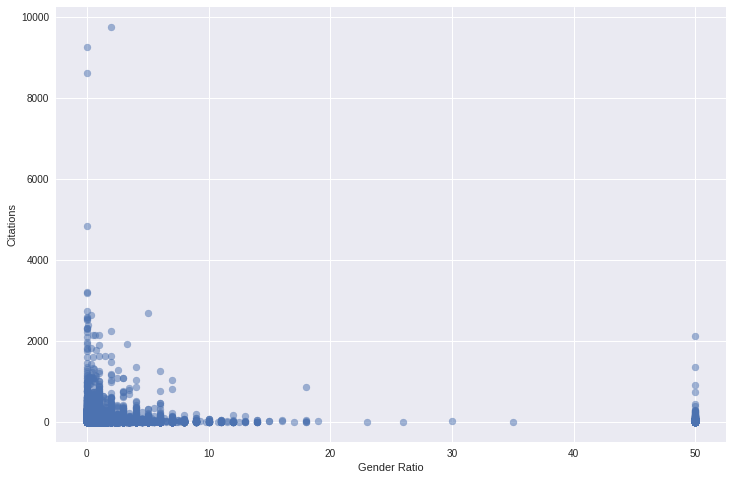

In [429]:
fig = plt.figure(1, figsize=(12, 8))
plt.scatter(papers_cgd['gender_ratio'], papers_cgd['citations'], alpha=0.5)
plt.ylabel('Citations')
plt.xlabel('Gender Ratio')
plt.show()

In [431]:
corr, _ = pearsonr(papers_cgd['gender_ratio'], papers_cgd['citations'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.015


## Content by gender

### Length of paper titles and gender

In [455]:
def length_titles(gender_group):
    lengths = papers[papers['title'].isin(papers_gender_dist[papers_gender_dist[gender_group]==1].index.values)]\
                    ['title'].map(lambda x: len(x))
    return lengths

#### Length of title in papers with most female authors vs most male authors

In [456]:
title_mostly_female_authors = length_titles('most_female')
title_mostly_male_authors = length_titles('most_male')

In [457]:
title_mostly_female_authors.describe()

count    10540.000000
mean        98.525617
std         32.103492
min         10.000000
25%         76.000000
50%         96.000000
75%        118.000000
max        271.000000
Name: title, dtype: float64

In [458]:
title_mostly_male_authors.describe()

count    21956.000000
mean        94.087220
std         31.028586
min         11.000000
25%         72.000000
50%         91.000000
75%        113.000000
max        273.000000
Name: title, dtype: float64

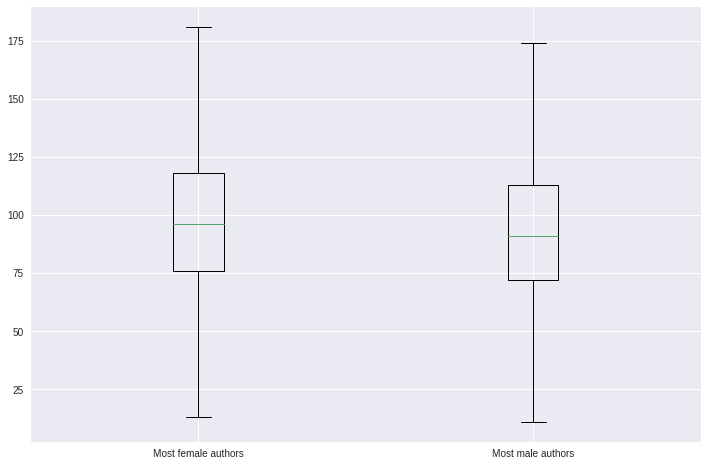

In [459]:
data_to_plot = [title_mostly_female_authors, title_mostly_male_authors]
# Create a figure instance
fig = plt.figure(1, figsize=(12, 8))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['Most female authors', 'Most male authors'])
# Create the boxplot
bp = ax.boxplot(data_to_plot, showfliers=False)

#### Are the different statistically significant?

In [461]:
ttest,pval = ttest_ind(title_mostly_female_authors,title_mostly_male_authors)
if pval < 0.05:
    print("The difference is statistically significant, p-value:", pval)
else:
    print("The difference is not statistically significant, p-value:",round(pval,3))

The difference is statistically significant, p-value: 9.059348654624269e-33


#### Length of title in papers with only female authors vs only male authors

In [463]:
title_only_female_authors = length_titles('only_female')
title_only_male_authors = length_titles('only_male')

In [464]:
title_only_female_authors.describe()

count    1442.000000
mean       97.625520
std        31.303974
min        21.000000
25%        75.000000
50%        95.000000
75%       116.000000
max       232.000000
Name: title, dtype: float64

In [465]:
title_only_male_authors.describe()

count    12687.000000
mean        91.163001
std         30.064879
min         11.000000
25%         70.000000
50%         88.000000
75%        110.000000
max        243.000000
Name: title, dtype: float64

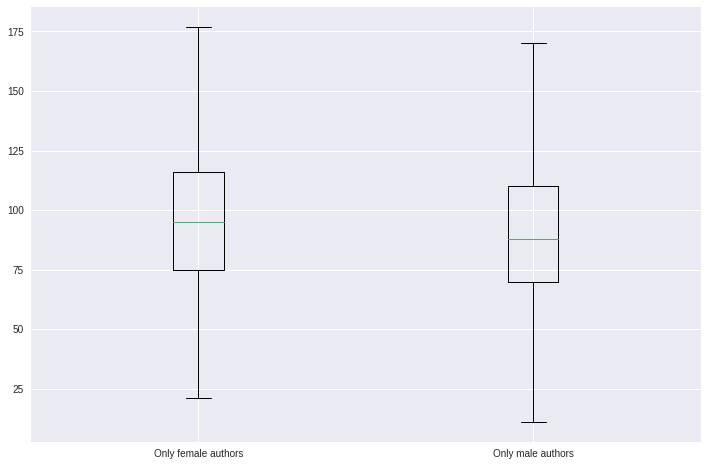

In [466]:
data_to_plot = [title_only_female_authors, title_only_male_authors]
# Create a figure instance
fig = plt.figure(1, figsize=(12, 8))
# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xticklabels(['Only female authors', 'Only male authors'])
# Create the boxplot
bp = ax.boxplot(data_to_plot, showfliers=False)

#### Are the different statistically significant?

In [468]:
ttest,pval = ttest_ind(title_only_female_authors,title_only_male_authors)
if pval < 0.05:
    print("The difference is statistically significant, p-value:", pval)
else:
    print("The difference is not statistically significant, p-value:",round(pval,3))

The difference is statistically significant, p-value: 1.4303364367593483e-14
